In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from konlpy.tag import Okt
t = Okt()

### first version of train data
(remove punctuation marks, correct spacing between words, split sentences, classify part of speech)

In [2]:
train = pd.read_csv('./datas/train_ver1', index_col=[0])
train.tail()

,comments,bias_label,gender_label,hate_label,news_title,comment_pos,title_pos
7891,"힘내세요,응원합니다",none,False,none,"허지웅 허투루 넘길 말 없었다,솔직하게 드러냈던 속 사정","[('힘내세요', 'Verb'), (',', 'Punctuation'), ('응원'...","[('허지웅', 'Noun'), ('허투루', 'Noun'), ('넘길', 'Ver..."
7892,"힘내세요,삼가 고인의 명복을 빕니다",none,False,none,이혜경 오 캐롤 공연 중 남편 오정욱 부 고 오열 속 발인 종합,"[('힘내세요', 'Verb'), (',', 'Punctuation'), ('삼가'...","[('이혜경', 'Noun'), ('오', 'Noun'), ('캐롤', 'Noun'..."
7893,힘내세용 항상 응원합니닷,none,False,none,설경구 송윤아 아들과 즐거운 하루 전 엄마니까요,"[('힘내세용', 'Verb'), ('항상', 'Noun'), ('응원', 'Nou...","[('설경구', 'Noun'), ('송윤아', 'Noun'), ('아들', 'Nou..."
7894,"힘내 소연기로 답해요,나도 53살 인데 이런 일 저런 일 다 있더라구 요인격을 믿습...",none,False,none,SC 현장 연예인 인생 협박 유감 미소 잃은 최민수 보복운전 혐의 2차 공판 종합,"[('힘내', 'Verb'), ('소', 'Modifier'), ('연기', 'No...","[('SC', 'Alpha'), ('현장', 'Noun'), ('연예인', 'Nou..."
7895,힘들면 관뒀어야지 그게 현명한 거다,none,False,none,단독 스태프 사망 사고 서른 이지만 결국 오늘 촬영 취소,"[('힘들면', 'Adjective'), ('관', 'Noun'), ('뒀어야지',...","[('단독', 'Noun'), ('스태프', 'Noun'), ('사망', 'Noun..."


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7896 entries, 0 to 7895
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comments      7896 non-null   object
 1   bias_label    7896 non-null   object
 2   gender_label  7896 non-null   bool  
 3   hate_label    7896 non-null   object
 4   news_title    7896 non-null   object
 5   comment_pos   7896 non-null   object
 6   title_pos     7896 non-null   object
dtypes: bool(1), object(6)
memory usage: 439.5+ KB


In [4]:
train.groupby('hate_label').describe()

comments                                                            \
              count unique                                                top   
hate_label                                                                      
hate           1911   1911  범죄를 범죄인 줄 모르고 ㅈㄹ 떠는 놈들이나 남자들 무데기로 있는 호텔방가서 ㅊ 먹...   
none           3486   3483                                     삼가 고인의 명복을 빕니다   
offensive      2499   2498                                              누구냐 넌   

                bias_label                      gender_label         ...  \
           freq      count unique     top  freq        count unique  ...   
hate_label                                                           ...   
hate          1       1911      3  gender   789         1911      2  ...   
none          4       3486      3    none  3273         3486      2  ...   
offensive     2       2499      3    none  1369         2499      2  ...   

                                         news_title      comment_pos         \
                                                top freq       count unique   
hate_label                                                                    
hate        트와이스 미나 입국에 활동 복귀 설 눈물 JYP 측 일정 참여 NO종합    8        1911   1911   
none          손현주 이 필모 서수연 결혼식 사회 인증 다시 뭉친 솔약국집 아들들   11        3486   3483   
offensive                 SW 이슈 월드와이드 방탄소년단 대기록의 시작    7        2499   2498   

                                                                   title_pos  \
                                                          top freq     count   
hate_label                                                                     
hate        [('김나영', 'Noun'), ('발톱', 'Noun'), ('의', 'Josa'...    1      1911   
none        [('삼가', 'Verb'), ('고인', 'Noun'), ('의', 'Josa')...    4      3486   
offensive      [('누구', 'Noun'), ('냐', 'Josa'), ('넌', 'Noun')]    2      2499   

                                                                           
           unique                                                top freq  
hate_label                                                                 
hate         1018  [('트와이스', 'Noun'), ('미나', 'Noun'), ('입국', 'Nou...    8  
none         1296  [('손현주', 'Noun'), ('이', 'Noun'), ('필모', 'Noun'...   11  
offensive    1183  [('SW', 'Alpha'), ('이슈', 'Noun'), ('월드', 'Noun...    7  

[3 rows x 24 columns]

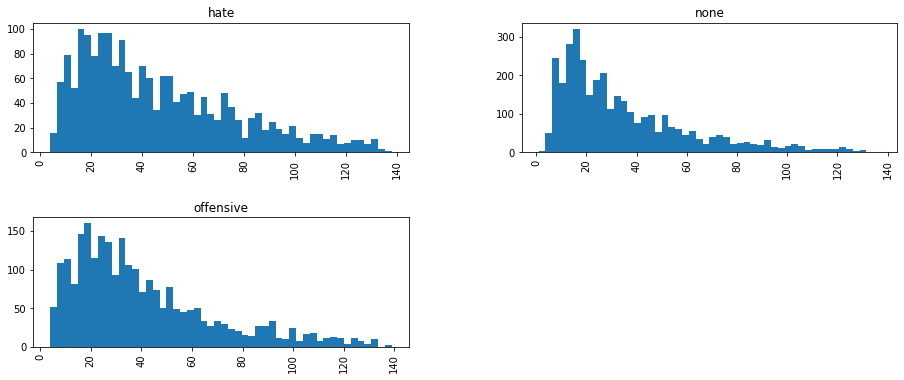

In [15]:
train['length'] = train['comments'].apply(len)
train.hist(column='length', by='hate_label', bins=50, figsize=(15,6));

In [16]:
stopwords = pd.read_csv('https://bab2min.tistory.com/attachment/cfile2.uf@241D6F475873C2B1010DEA.txt', sep='\t', header=None, names=['형태','품사','비율'])
stopwords_list = stopwords['형태'].tolist()

In [21]:
def process_text(text):
    clean_words = [word for word in text if word not in stopwords_list]
    return clean_words

train['comments'] = train['comments'].apply(process_text)
train['comments'] = [''.join(l) for l in train['comments']]

In [22]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, class_train, class_test = train_test_split(train['comments'], train['hate_label'], test_size=0.2)

In [23]:
from sklearn.pipeline import Pipeline
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [24]:
text_clf.fit(msg_train, class_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [26]:
from sklearn.metrics import classification_report

predictions = text_clf.predict(msg_test)
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

        hate       0.68      0.14      0.23       377
        none       0.54      0.84      0.66       727
   offensive       0.38      0.29      0.33       476

    accuracy                           0.51      1580
   macro avg       0.53      0.42      0.40      1580
weighted avg       0.52      0.51      0.45      1580



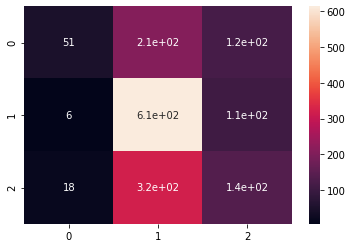

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(class_test, predictions), annot=True);

In [5]:
dev = pd.read_csv('./datas/dev.hate.csv')
dev.rename(columns={'label': 'hate_label'}, inplace=True)

In [6]:
def t_tokenizer(text):
    tokens_ko = t.morphs(text)
    return tokens_ko

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=t_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train['comments'])
tfidf_matrix_train = tfidf_vect.transform(train['comments'])

In [10]:
mulnb = MultinomialNB()
mulnb.fit(tfidf_matrix_train, train['hate_label'])

MultinomialNB()

In [11]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

tfidf_matrix_dev = tfidf_vect.transform(dev['comments'])
preds = mulnb.predict(tfidf_matrix_dev)
accuracy_score(dev['hate_label'], preds), f1_score(preds, dev['hate_label'], average='macro')

(0.5456475583864119, 0.5179910560715514)

### trial with second version of train data
(remove punctuation marks, classify part of speech)

In [31]:
train_2 = pd.read_csv('./datas/train_ver2', index_col=[0])
train_2.tail()

,comments,bias_label,gender_label,hate_label,news_title,comment_pos,title_pos
7891,힘내세요 응원합니다,none,False,none,허지웅 허투루 넘길 말 없었다 솔직하게 드러냈던 속사정,"[('힘내세요', 'Verb'), ('응원', 'Noun'), ('합니다', 'Ve...","[('허지웅', 'Noun'), ('허투루', 'Noun'), ('넘길', 'Ver..."
7892,힘내세요삼가 고인의 명복을 빕니다,none,False,none,이혜경 오 캐롤 공연 중 남편 오정욱 부고 오열 속 발인 종합,"[('힘내세요', 'Verb'), ('삼가', 'Verb'), ('고인', 'Nou...","[('이혜경', 'Noun'), ('오', 'Noun'), ('캐롤', 'Noun'..."
7893,힘내세용 항상 응원합니닷,none,False,none,설경구 송윤아 아들과 즐거운 하루 전 엄마니까요,"[('힘내세용', 'Verb'), ('항상', 'Noun'), ('응원', 'Nou...","[('설경구', 'Noun'), ('송윤아', 'Noun'), ('아들', 'Nou..."
7894,힘내소연기로 답해요나도 53살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅,none,False,none,SC현장연예인 인생 협박 유감 미소잃은 최민수 보복운전 혐의 2차 공판종합,"[('힘내소', 'Verb'), ('연기', 'Noun'), ('로', 'Josa'...","[('SC', 'Alpha'), ('현장', 'Noun'), ('연예인', 'Nou..."
7895,힘들면 관뒀어야지 그게 현명한거다,none,False,none,단독스태프 사망사고 서른이지만 결국 오늘 촬영 취소,"[('힘들면', 'Adjective'), ('관', 'Noun'), ('뒀어야지',...","[('단독', 'Noun'), ('스태프', 'Noun'), ('사망', 'Noun..."


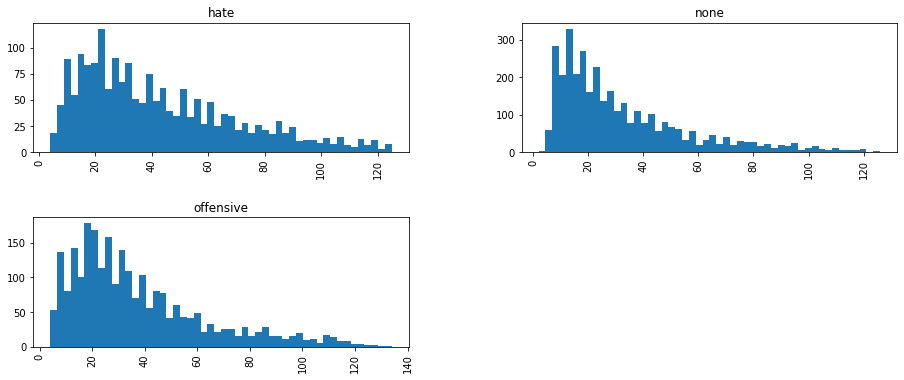

In [32]:
train_2['length'] = train_2['comments'].apply(len)
train_2.hist(column='length', by='hate_label', bins=50, figsize=(15,6));

In [33]:
train_2['comments'] = train_2['comments'].apply(process_text)
train_2['comments'] = [''.join(l) for l in train_2['comments']]

In [34]:
msg_train, msg_test, class_train, class_test = train_test_split(train_2['comments'], train_2['hate_label'], test_size=0.2)
text_clf.fit(msg_train, class_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [35]:
predictions = text_clf.predict(msg_test)
print(classification_report(class_test, predictions))

              precision    recall  f1-score   support

        hate       0.57      0.10      0.18       353
        none       0.49      0.90      0.64       703
   offensive       0.43      0.19      0.27       524

    accuracy                           0.49      1580
   macro avg       0.50      0.40      0.36      1580
weighted avg       0.49      0.49      0.41      1580



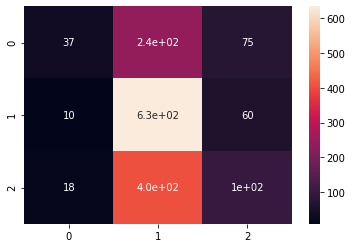

In [36]:
sns.heatmap(confusion_matrix(class_test, predictions), annot=True);